<a href="https://colab.research.google.com/github/vinodnbhat/AIML-CEP-2021-Assignments/blob/main/VGG_CIFAR10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# Import required libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
import torch.optim.lr_scheduler as lr_scheduler
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
import numpy as np
import random
import time

In [3]:
SEED = 1234
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)

**CIFAR Dataset**

In [4]:
ROOT = '.data'

# Downloading Cifar10 dataset from torchvision datasets
train_data = datasets.CIFAR10(root = ROOT,
                              train = True,
                              download = True)

mean = train_data.data.mean() / 255
std = train_data.data.std() / 255

print(f'Calculated mean: {mean}')
print(f'Calculated std: {std}')

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting .data/cifar-10-python.tar.gz to .data
Calculated mean: 0.4733630004850899
Calculated std: 0.2515689250632208


In [5]:
print(train_data.data.shape)

(50000, 32, 32, 3)


In [6]:
train_transforms = transforms.Compose([
                                       transforms.ToTensor(),
                                       transforms.Normalize(mean = [mean], std = [std])
                                      ])

test_transforms = transforms.Compose([
                                       transforms.ToTensor(),
                                       transforms.Normalize(mean = [mean], std = [std])
                                      ])

In [7]:
train_set = datasets.CIFAR10(root = ROOT,
                             train = True,
                             download = True,
                             transform = train_transforms)

test_set = datasets.CIFAR10(root = ROOT,
                             train = False,
                             download = True,
                             transform = train_transforms)

Files already downloaded and verified
Files already downloaded and verified


In [8]:
print(train_set.data.shape)

(50000, 32, 32, 3)


In [9]:
print(test_set.data.shape)

(10000, 32, 32, 3)


In [11]:
print(f'Number of training samples: {len(train_set)}')
print(f'Number of testing samples: {len(test_set)}')

Number of training samples: 50000
Number of testing samples: 10000


In [12]:
batch_size = 64

train_loader = data.DataLoader(train_set,
                               shuffle = True,
                               batch_size = batch_size)

test_loader = data.DataLoader(test_set,
                              batch_size = batch_size)

In [13]:
# Checking the bacth dimensions
for images, labels in train_loader:
  print('Image batch dimensions:', images.shape)
  print('Label batch dimensions:', labels.shape)
  break

Image batch dimensions: torch.Size([64, 3, 32, 32])
Label batch dimensions: torch.Size([64])


In [14]:
### Model Settings ###

# Hyperparameters
learning_rate = 0.01

# Architecture
num_classes = 10

In [16]:
class VGG(nn.Module):
  def two_conv_pools(self, in_channels, f1, f2):
    s = nn.Sequential(
        nn.Conv2d(in_channels, f1, kernel_size = 3, stride = 1, padding = 1),
        nn.BatchNorm2d(f1),
        nn.ReLU(inplace = True),
        nn.Conv2d(f1, f2, kernel_size = 3, stride = 1, padding = 1),
        nn.BatchNorm2d(f2),
        nn.ReLU(inplace = True),
        nn.MaxPool2d(kernel_size = 2, stride = 2),
    )
    return s

  def three_conv_pools(self, in_channels, f1, f2, f3):
    s = nn.Sequential(
        nn.Conv2d(in_channels, f1, kernel_size = 3, stride = 1, padding = 1),
        nn.BatchNorm2d(f1),
        nn.ReLU(inplace = True),
        nn.Conv2d(f1, f2, kernel_size = 3, stride = 1, padding = 1),
        nn.BatchNorm2d(f2),
        nn.ReLU(inplace = True),
        nn.Conv2d(f2, f3, kernel_size = 3, stride = 1, padding = 1),
        nn.BatchNorm2d(f3),
        nn.ReLU(inplace = True),
        nn.MaxPool2d(kernel_size = 2, stride = 2),
    )
    return s  

  def __init__(self, num_classes = 10):
    super(VGG, self).__init__()
    self.l1 = self.two_conv_pools(3, 16, 16)            #32x32x3 => 32x32x(f1=16) => 32x32x(f2=16) => 16x16x(f2=16) 
    self.l2 = self.two_conv_pools(16, 32, 32)           #16x16x16 => 16x16x(f1=32) => 16x16x(f2=32) => 8x8x(f2=32)
    self.l3 = self.three_conv_pools(32, 64, 64, 64)     #8x8x32 => 8x8x64 => 8x8x64 => 8x8x64=> 4x4x64
    self.l4 = self.three_conv_pools(64, 64, 64, 64)     #4x4x64 => 4x4x64 => 4x4x64 => 4x4x64 => 2x2x64

    self.classifier = nn.Sequential(
        nn.Linear(64 * 2 *2, 32),
        nn.BatchNorm1d(32),
        nn.ReLU(inplace = True),
        nn.Dropout(p = 0.5),
        nn.Linear(32, num_classes),
    )

  def forward(self, x):
    x =self.l1(x)
    x = self.l2(x)
    x = self.l3(x)
    x = self.l4(x)
    x = x.view(x.size(0), -1)
    x = self.classifier(x)
    logits = x
    probas = F.log_softmax(x, dim = 1)
    return logits, probas

In [17]:
# Initialize the model
model = VGG()

In [18]:
def count_parameters(model):
  return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 229,370 trainable parameters


In [19]:
optimizer = torch.optim.Adam(model.parameters(), lr =learning_rate)

In [20]:
lossfn = nn.CrossEntropyLoss()

In [21]:
if torch.cuda.is_available():
  print('cuda is available. Using cuda..')
else:
  print('cuda is not available. Using CPU..')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

cuda is not available. Using CPU..


In [22]:
model = model.to(device)
lossfn = lossfn.to(device)

In [23]:
def epoch_time(start_time, end_time):
  elapsed_time = end_time - start_time
  elapsed_mins = int(elapsed_time / 60)
  elapsed_secs = elapsed_time - (elapsed_mins * 60)
  return elapsed_mins, elapsed_secs

In [24]:
# Compute the Accuracy
def calculate_accuracy(y_pred, y):
  top_pred = y_pred.argmax(1, keepdim = True)
  correct = top_pred.eq(y.view_as(top_pred)).sum()
  acc = correct.float() / y.shape[0]
  return acc

In [25]:
def train(model, iterator, optimizer, criterion, device):
  epoch_loss = 0
  epoch_acc = 0

  model.train()

  for (x, y) in iterator:

    x = x.to(device)
    y = y.to(device)

    optimizer.zero_grad()

    y_pred_logits, y_pred_probas = model(x)

    loss = lossfn(y_pred_logits, y)

    acc = calculate_accuracy(y_pred_probas, y)

    loss.backward()

    optimizer.step()

    epoch_loss += loss.item()
    epoch_acc += acc.item()

  return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [26]:
def eval(model, iterator, criterion, device):
  epoch_loss = 0
  epoch_acc = 0

  model.eval()

  with torch.no_grad():

    for (x, y) in iterator:

      x = x.to(device)
      y = y.to(device)

      y_pred_logits, y_pred_probas = model(x)

      loss = lossfn(y_pred_logits, y)

      acc = calculate_accuracy(y_pred_probas, y)

      epoch_loss += loss.item()
      epoch_acc += acc.item()

  return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [27]:
save_model = False
EPOCHS = 40

patience_early_stopping = 3 #training will stop if model performance does not improve for these many consecutive epochs
count = 0 #counter for checking patience level

prev_test_acc = 0 #initializing prev test accuracy for early stopping condition
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode = 'max', factor = 0.2, patience = 1) #learning rate scheduler, update learning rate by 
#factor of 0.2 if test accuracy does not improve for patience+1 consecutive epochs

for epoch in range(EPOCHS):
  print("\nLearning rate for epoch {0}: {1}".format(epoch+1, optimizer.state_dict()['param_groups'][0]['lr']))
  start_time = time.perf_counter()

  train_loss, train_acc = train(model, train_loader, optimizer, lossfn, device)
  
  if save_model:
    torch.save(model.state.dict(), 'vgg_model.pt')

  if epoch % 1 == 0: #for every epoch we shall compute the test accuracy
    test_loss, test_acc = eval(model, test_loader, lossfn, device)

    if test_acc > prev_test_acc: #check if test accuracy for current epoch has improved compared to previous epoch
      count = 0 #if accuracy improves reset counter to 0
    else:
      count += 1 #otherwise increment current counter

    prev_test_acc = test_acc

  scheduler.step(test_acc) #updates learning rate

  end_time = time.perf_counter()

  epoch_mins, epoch_secs = epoch_time(start_time, end_time)

  print(f'Epoch: {epoch+1:2} | Epoch Time: {epoch_mins}m {epoch_secs}s')
  print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc:.2f}%')
  if epoch % 1 == 0:  #for every epoch we shall print the test loss and test accuracy 
    print(f'\tTest Loss: {test_loss:.3f} | Test Acc: {test_acc:.2f}% \n')

  if count == patience_early_stopping:
    print(f'early stopping as accuracy did not improve for {patience_early_stopping} consecutive epochs')
    break




Learning rate for epoch 1: 0.01
Epoch:  1 | Epoch Time: 2m 48.59388716699999s
	Train Loss: 1.774 | Train Acc: 0.31%
	Test Loss: 1.549 | Test Acc: 0.42% 


Learning rate for epoch 2: 0.01
Epoch:  2 | Epoch Time: 2m 51.03468176700005s
	Train Loss: 1.367 | Train Acc: 0.50%
	Test Loss: 1.197 | Test Acc: 0.56% 


Learning rate for epoch 3: 0.01
Epoch:  3 | Epoch Time: 2m 49.429993836999984s
	Train Loss: 1.161 | Train Acc: 0.59%
	Test Loss: 1.100 | Test Acc: 0.61% 


Learning rate for epoch 4: 0.01
Epoch:  4 | Epoch Time: 2m 49.51493122399995s
	Train Loss: 1.028 | Train Acc: 0.64%
	Test Loss: 1.014 | Test Acc: 0.64% 


Learning rate for epoch 5: 0.01
Epoch:  5 | Epoch Time: 2m 49.882456677999926s
	Train Loss: 0.932 | Train Acc: 0.69%
	Test Loss: 0.861 | Test Acc: 0.70% 


Learning rate for epoch 6: 0.01
Epoch:  6 | Epoch Time: 2m 50.5809319519999s
	Train Loss: 0.861 | Train Acc: 0.71%
	Test Loss: 1.014 | Test Acc: 0.67% 


Learning rate for epoch 7: 0.01
Epoch:  7 | Epoch Time: 2m 48.322593

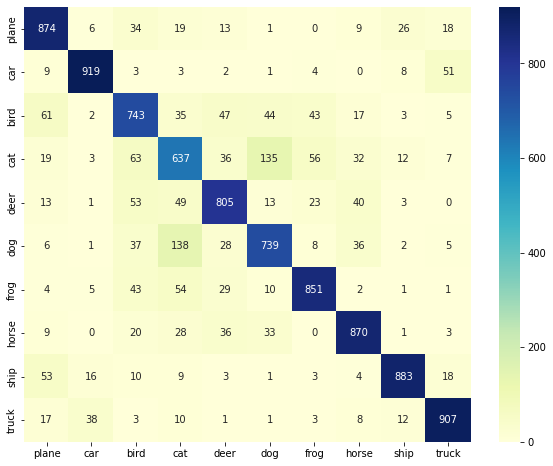

In [34]:
## predictions of test images. The vertical line shows the true labels and horizontal line shows the predicted labels.

import pandas as pd
import seaborn as sns


classes = ['plane', 'car' , 'bird', 'cat', 'deer', 'dog','frog', 'horse', 'ship', 'truck'] 

heatmap = pd.DataFrame(data=0,index=classes,columns=classes)
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        y_pred_logits, y_pred_probas = model(images)
        _, predicted = torch.max(y_pred_probas,1)
        c = (predicted == labels).squeeze()
        for i in range(labels.shape[0]):
            true_label = labels[i].item()
            predicted_label = predicted[i].item()
            heatmap.iloc[true_label,predicted_label] += 1
_, ax = plt.subplots(figsize=(10, 8))
ax = sns.heatmap(heatmap, annot=True, fmt="d",cmap="YlGnBu")
plt.show()
